In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install Augmentor

In [3]:
import Augmentor
import cv2
import numpy as np
from PIL import Image
from Augmentor.Operations import Operation

class SharpenImage(Operation):
    def __init__(self, probability):
        Operation.__init__(self, probability)

    def perform_operation(self, images):
        sharpened_images = []
        for image in images:
            try:
                # Convert image to NumPy array
                np_image = np.array(image)
                # Convert image to grayscale
                gray = cv2.cvtColor(np_image, cv2.COLOR_RGB2GRAY)
                # Apply GaussianBlur to remove noise
                blurred = cv2.GaussianBlur(gray, (3, 3), 0)
                # Apply Unsharp Masking for sharpening
                sharpened = cv2.addWeighted(gray, 1.5, blurred, -0.5, 0)
                # Convert back to RGB
                sharpened_rgb = cv2.cvtColor(sharpened, cv2.COLOR_GRAY2RGB)
                # Ensure that the output image has the same dimensions as the input image
                sharpened_rgb = Image.fromarray(sharpened_rgb).resize(image.size)
                sharpened_images.append(sharpened_rgb)
            except Exception as e:
                print(f"Error processing image: {e}")
        return sharpened_images

p = Augmentor.Pipeline("/content/drive/MyDrive/Newdata",output_directory="/content/drive/MyDrive/output")

p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)

p.random_distortion(probability=0.5, grid_width=4, grid_height=4, magnitude=8)

p.random_brightness(probability=0.5, min_factor=0.5, max_factor=1.5)

p.random_contrast(probability=0.5, min_factor=0.5, max_factor=1.5)


p.add_operation(SharpenImage(probability=1.0))

p.flip_random(probability=0.5)

p.random_erasing(probability=0.5, rectangle_area=0.2)

p.sample(5200)





Initialised with 689 image(s) found.
Output directory set to /content/drive/MyDrive/output.

Processing <PIL.Image.Image image mode=RGB size=256x256 at 0x7F9F156ABB80>: 100%|██████████| 5200/5200 [02:53<00:00, 29.97 Samples/s]


In [4]:
import pathlib
import tensorflow as tf

data_dir = pathlib.Path('/content/drive/MyDrive/output')
img_height=224
img_width=224


In [5]:
train_ds  = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=32)


Found 5200 files belonging to 5 classes.
Using 4160 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=32)


Found 5200 files belonging to 5 classes.
Using 1040 files for validation.


In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [8]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

0.006062923 0.94075525


In [9]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D

base_model1 = InceptionV3(
                    input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)
# Freeze the first 10 layers
for layer in base_model1.layers[:10]:
    layer.trainable = False
x = base_model1.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
predictions1 = Dense(5, activation='softmax')(x)
model1 = Model(inputs=base_model1.inputs, outputs=predictions1)

87910968/87910968 [==============================] - 0s 0us/step


In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

base_model3 = ResNet50(
                    input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)
# Freeze the first 10 layers
for layer in base_model3.layers[:10]:
    layer.trainable = False

x = base_model3.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions3 = Dense(5, activation='softmax')(x)
model3 = Model(inputs=base_model3.inputs, outputs=predictions3)


94765736/94765736 [==============================] - 1s 0us/step


In [11]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

base_model5 = MobileNet(
                    input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)
# Freeze the first 10 layers
for layer in base_model5.layers[:10]:
    layer.trainable = False

x = base_model5.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions2 = Dense(5, activation='softmax')(x)
model5 = Model(inputs=base_model5.inputs, outputs=predictions2)


17225924/17225924 [==============================] - 0s 0us/step


In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Checkpoint to save best model per epoch

model_filepath = "/content/drive/MyDrive/kol/model-{epoch:02d}-{val_accuracy:.4f}.hdf5"

checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


In [15]:
model1.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model3.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model5.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [16]:
history1=model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=35)


Epoch 1/35


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


130/130 [==============================] - 94s 291ms/step - loss: 1.0853 - accuracy: 0.5894 - val_loss: 1.8916 - val_accuracy: 0.3231
Epoch 2/35
130/130 [==============================] - 29s 222ms/step - loss: 0.7316 - accuracy: 0.7224 - val_loss: 2.2799 - val_accuracy: 0.4010
Epoch 3/35
130/130 [==============================] - 29s 220ms/step - loss: 0.5109 - accuracy: 0.8043 - val_loss: 0.8417 - val_accuracy: 0.6865
Epoch 4/35
130/130 [==============================] - 29s 223ms/step - loss: 0.3972 - accuracy: 0.8572 - val_loss: 2.3554 - val_accuracy: 0.5135
Epoch 5/35
130/130 [==============================] - 29s 221ms/step - loss: 0.3309 - accuracy: 0.8841 - val_loss: 0.5881 - val_accuracy: 0.7990
Epoch 6/35
130/130 [==============================] - 29s 221ms/step - loss: 0.2552 - accuracy: 0.9142 - val_loss: 1.8911 - val_accuracy: 0.5394
Epoch 7/35
130/130 [==============================] - 29s 219ms/step - loss: 0.2351 - accuracy: 0.9236 - val_loss: 0.6333 - val_accuracy: 0.7

In [17]:
model1.save('neomodel1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


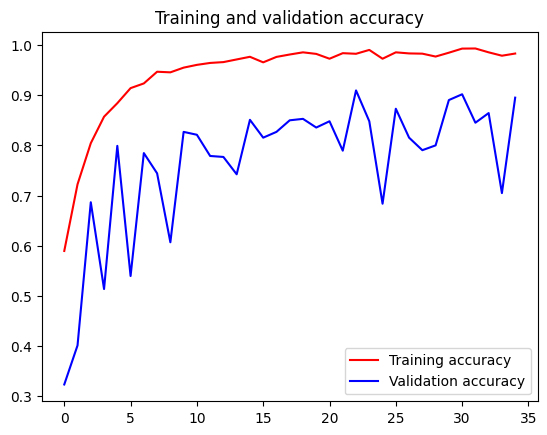

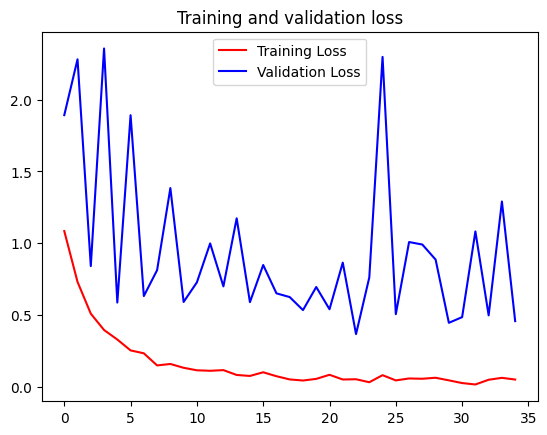

In [18]:
import matplotlib.pyplot as plt

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [19]:
history3=model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=36)

Epoch 1/36
130/130 [==============================] - 79s 343ms/step - loss: 1.0347 - accuracy: 0.6380 - val_loss: 10.9416 - val_accuracy: 0.1760
Epoch 2/36
130/130 [==============================] - 42s 322ms/step - loss: 0.6428 - accuracy: 0.7452 - val_loss: 1.7236 - val_accuracy: 0.5904
Epoch 3/36
130/130 [==============================] - 42s 324ms/step - loss: 0.4737 - accuracy: 0.8103 - val_loss: 0.8464 - val_accuracy: 0.6000
Epoch 4/36
130/130 [==============================] - 42s 322ms/step - loss: 0.3630 - accuracy: 0.8584 - val_loss: 1.0450 - val_accuracy: 0.6817
Epoch 5/36
130/130 [==============================] - 42s 323ms/step - loss: 0.3191 - accuracy: 0.8820 - val_loss: 1.5370 - val_accuracy: 0.6673
Epoch 6/36
130/130 [==============================] - 42s 323ms/step - loss: 0.2254 - accuracy: 0.9166 - val_loss: 1.1195 - val_accuracy: 0.6644
Epoch 7/36
130/130 [==============================] - 44s 340ms/step - loss: 0.2106 - accuracy: 0.9200 - val_loss: 1.5049 - val_a

In [20]:
model3.save('neomodel3.h5')

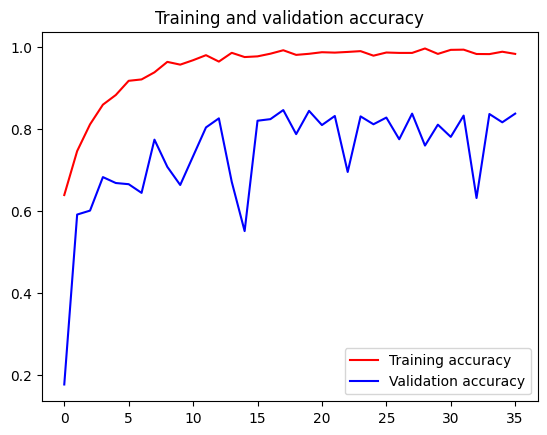

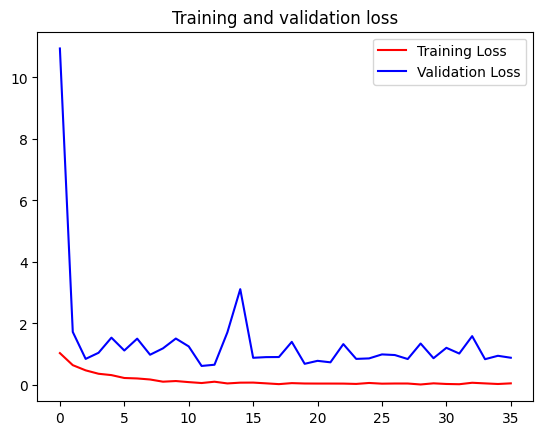

In [21]:
import matplotlib.pyplot as plt

acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
history5=model5.fit(
  train_ds,
  validation_data=val_ds,
  epochs=22)

Epoch 1/22
130/130 [==============================] - 26s 105ms/step - loss: 1.0030 - accuracy: 0.6226 - val_loss: 4.1180 - val_accuracy: 0.1962
Epoch 2/22
130/130 [==============================] - 13s 98ms/step - loss: 0.5425 - accuracy: 0.7846 - val_loss: 1.4545 - val_accuracy: 0.5337
Epoch 3/22
130/130 [==============================] - 13s 99ms/step - loss: 0.3649 - accuracy: 0.8659 - val_loss: 1.3693 - val_accuracy: 0.6644
Epoch 4/22
130/130 [==============================] - 13s 99ms/step - loss: 0.2442 - accuracy: 0.9087 - val_loss: 1.1375 - val_accuracy: 0.6288
Epoch 5/22
130/130 [==============================] - 13s 98ms/step - loss: 0.2340 - accuracy: 0.9171 - val_loss: 1.3544 - val_accuracy: 0.6683
Epoch 6/22
130/130 [==============================] - 13s 99ms/step - loss: 0.1899 - accuracy: 0.9341 - val_loss: 1.2132 - val_accuracy: 0.6837
Epoch 7/22
130/130 [==============================] - 13s 98ms/step - loss: 0.1439 - accuracy: 0.9517 - val_loss: 1.0766 - val_accuracy

In [23]:
model5.save('neomodel5.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


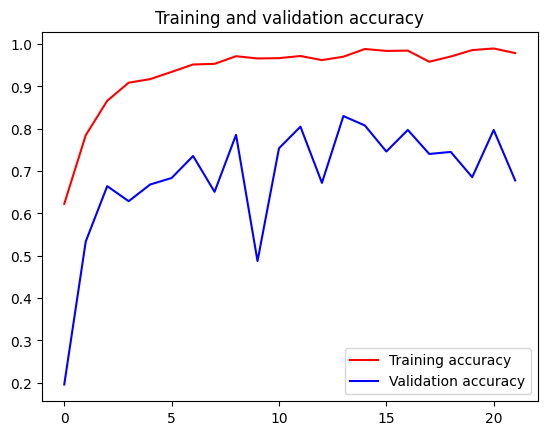

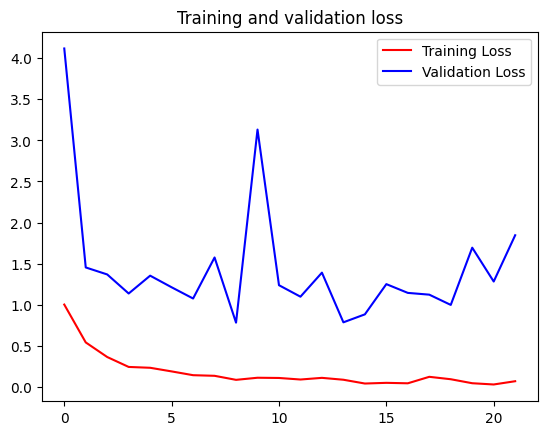

In [24]:
import matplotlib.pyplot as plt

acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']
loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [33]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average

model_1 = load_model('/content/neomodel1.h5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='name_of_model_1')

model_3 = load_model('/content/neomodel3.h5')
model_3 = Model(inputs=model_3.inputs,
                outputs=model_3.outputs,
                name='name_of_model_3')

#model_5 = load_model('/content/neomodel5.h5')
#model_5 = Model(inputs=model_5.inputs,
 #               outputs=model_5.outputs,
  #              name='name_of_model_5')

models = [model_1, model_3]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

ensemble_model.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])


In [34]:
history00=ensemble_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=25)

Epoch 1/25
130/130 [==============================] - 133s 563ms/step - loss: 0.0519 - accuracy: 0.9909 - val_loss: 1.9349 - val_accuracy: 0.5808
Epoch 2/25
130/130 [==============================] - 71s 545ms/step - loss: 0.2353 - accuracy: 0.9416 - val_loss: 0.8808 - val_accuracy: 0.7856
Epoch 3/25
130/130 [==============================] - 70s 536ms/step - loss: 0.0603 - accuracy: 0.9875 - val_loss: 0.4396 - val_accuracy: 0.8904
Epoch 4/25
130/130 [==============================] - 70s 536ms/step - loss: 0.0402 - accuracy: 0.9935 - val_loss: 0.4858 - val_accuracy: 0.8750
Epoch 5/25
130/130 [==============================] - 72s 552ms/step - loss: 0.0367 - accuracy: 0.9928 - val_loss: 0.8018 - val_accuracy: 0.8654
Epoch 6/25
130/130 [==============================] - 70s 536ms/step - loss: 0.1430 - accuracy: 0.9644 - val_loss: 2.6343 - val_accuracy: 0.5904
Epoch 7/25
130/130 [==============================] - 71s 544ms/step - loss: 0.2956 - accuracy: 0.9017 - val_loss: 3.6176 - val_a

In [35]:
ensemble_model.save('combinedmodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


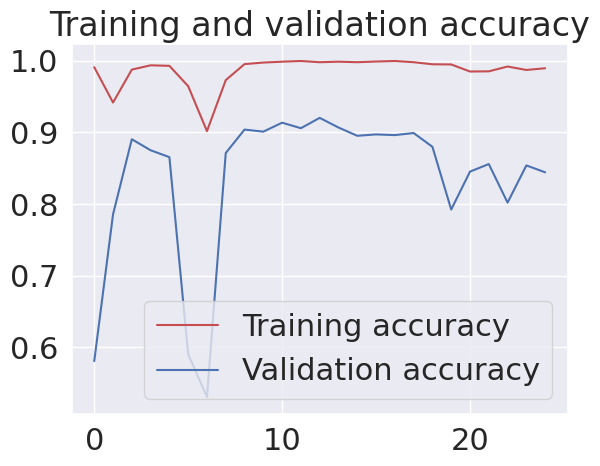

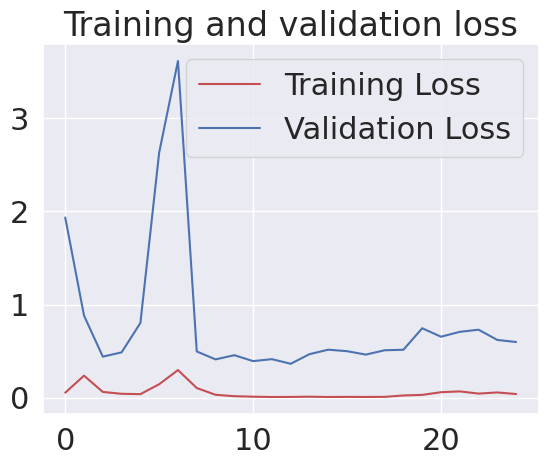

In [36]:
import matplotlib.pyplot as plt

acc = history00.history['accuracy']
val_acc = history00.history['val_accuracy']
loss = history00.history['loss']
val_loss = history00.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [37]:
train_label = np.concatenate([y for x, y in train_ds], axis=0)
print(train_label.shape)

test_label = np.concatenate([y for x, y in val_ds], axis=0)
print(test_label.shape)


(4160,)
(1040,)


In [38]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#Confution Matrix and Classification Report
import matplotlib.pyplot as plt


Y_pred = ensemble_model.predict_generator(val_ds, 1600)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(test_label, y_pred)
print(cm)
print('Classification Report')
target_names = ['bell-pepper-bacterial-spot', 'bell-pepper-healthy', 'Mosaic-virus', 'curling-leaves', 'yellowing-leaves']
print(classification_report(test_label, y_pred, target_names=target_names))



<ipython-input-38-99eb365f5fdf>:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = ensemble_model.predict_generator(val_ds, 1600)


Confusion Matrix
[[ 35   3  13   5   1]
 [  0 215   0   1   1]
 [  3  43 383  14   5]
 [  1   6  54 109   0]
 [  0   7   5   0 136]]
Classification Report
                            precision    recall  f1-score   support

bell-pepper-bacterial-spot       0.90      0.61      0.73        57
       bell-pepper-healthy       0.78      0.99      0.88       217
              Mosaic-virus       0.84      0.85      0.85       448
            curling-leaves       0.84      0.64      0.73       170
          yellowing-leaves       0.95      0.92      0.93       148

                  accuracy                           0.84      1040
                 macro avg       0.86      0.80      0.82      1040
              weighted avg       0.85      0.84      0.84      1040



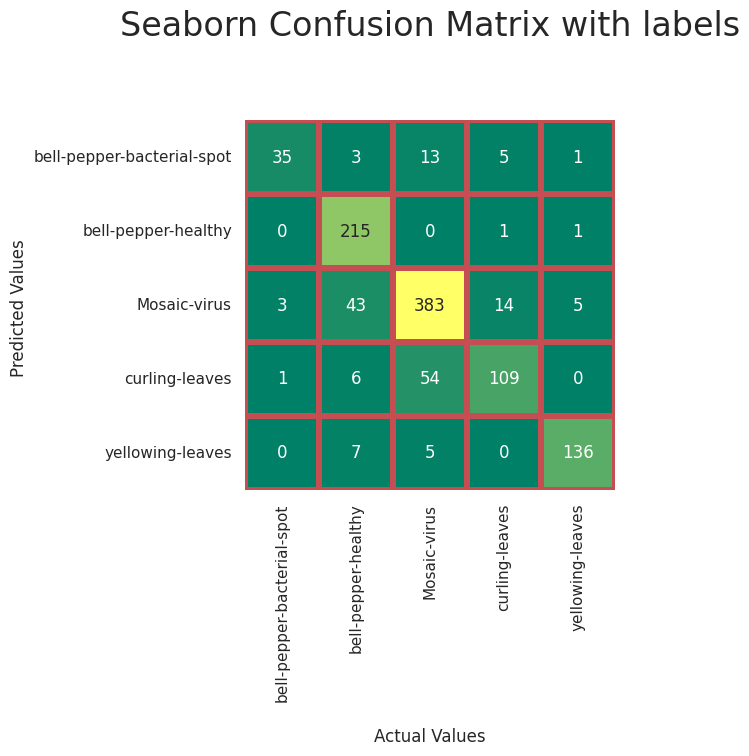

In [39]:
import seaborn as sns
sns.set(font_scale=1.0)
ax=sns.heatmap(cm, annot=True, cmap='summer', cbar=False, linewidths=3, linecolor='r', square=True, xticklabels=target_names,yticklabels=target_names,fmt='')
#sns.heatmap(cm, annot=True,annot_kws={"size": 22})
sns.set(font_scale = 2.0)
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nActual Values')
ax.set_ylabel('Predicted Values ');

In [40]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average

model_1 = load_model('/content/neomodel1.h5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='name_of_model_1')

model_3 = load_model('/content/neomodel3.h5')
model_3 = Model(inputs=model_3.inputs,
                outputs=model_3.outputs,
                name='name_of_model_3')

model_5 = load_model('/content/neomodel5.h5')
model_5 = Model(inputs=model_5.inputs,
                outputs=model_5.outputs,
                name='name_of_model_5')

models = [model_1, model_3, model_5]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

ensemble_model.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])


In [42]:
history=ensemble_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=8)

Epoch 1/8
130/130 [==============================] - 82s 629ms/step - loss: 0.0579 - accuracy: 0.9940 - val_loss: 0.4783 - val_accuracy: 0.8933
Epoch 2/8
130/130 [==============================] - 82s 628ms/step - loss: 0.0456 - accuracy: 0.9964 - val_loss: 0.4876 - val_accuracy: 0.9010
Epoch 3/8
130/130 [==============================] - 86s 661ms/step - loss: 0.0366 - accuracy: 0.9978 - val_loss: 0.4181 - val_accuracy: 0.9144
Epoch 4/8
130/130 [==============================] - 82s 628ms/step - loss: 0.0321 - accuracy: 0.9974 - val_loss: 0.4882 - val_accuracy: 0.9019
Epoch 5/8
130/130 [==============================] - 86s 661ms/step - loss: 0.0364 - accuracy: 0.9976 - val_loss: 0.4419 - val_accuracy: 0.8990
Epoch 6/8
130/130 [==============================] - 82s 628ms/step - loss: 0.0361 - accuracy: 0.9983 - val_loss: 0.4255 - val_accuracy: 0.9029
Epoch 7/8
130/130 [==============================] - 82s 628ms/step - loss: 0.0373 - accuracy: 0.9981 - val_loss: 0.4385 - val_accuracy:

In [43]:
ensemble_model.save('finalmodelv2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


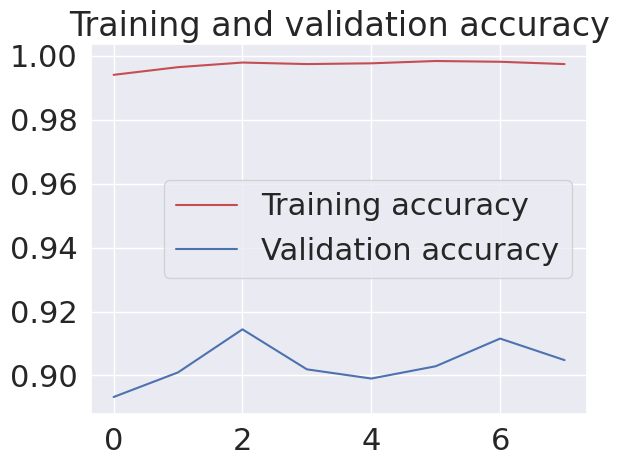

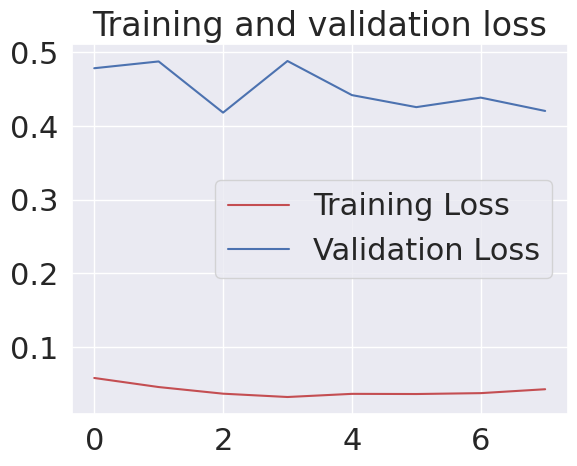

In [44]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [45]:
train_label = np.concatenate([y for x, y in train_ds], axis=0)
print(train_label.shape)

test_label = np.concatenate([y for x, y in val_ds], axis=0)
print(test_label.shape)



(4160,)
(1040,)


In [46]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#Confution Matrix and Classification Report
import matplotlib.pyplot as plt


Y_pred = ensemble_model.predict_generator(val_ds, 1600)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(test_label, y_pred)
print(cm)
print('Classification Report')
target_names = ['bell-pepper-bacterial-spot', 'bell-pepper-healthy', 'Mosaic-virus', 'curling-leaves', 'yellowing-leaves']
print(classification_report(test_label, y_pred, target_names=target_names))



<ipython-input-46-99eb365f5fdf>:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = ensemble_model.predict_generator(val_ds, 1600)


Confusion Matrix
[[ 33   0  19   4   1]
 [  0 208   7   1   1]
 [  4   4 420  17   3]
 [  0   1  35 134   0]
 [  0   0   2   0 146]]
Classification Report
                            precision    recall  f1-score   support

bell-pepper-bacterial-spot       0.89      0.58      0.70        57
       bell-pepper-healthy       0.98      0.96      0.97       217
              Mosaic-virus       0.87      0.94      0.90       448
            curling-leaves       0.86      0.79      0.82       170
          yellowing-leaves       0.97      0.99      0.98       148

                  accuracy                           0.90      1040
                 macro avg       0.91      0.85      0.87      1040
              weighted avg       0.91      0.90      0.90      1040



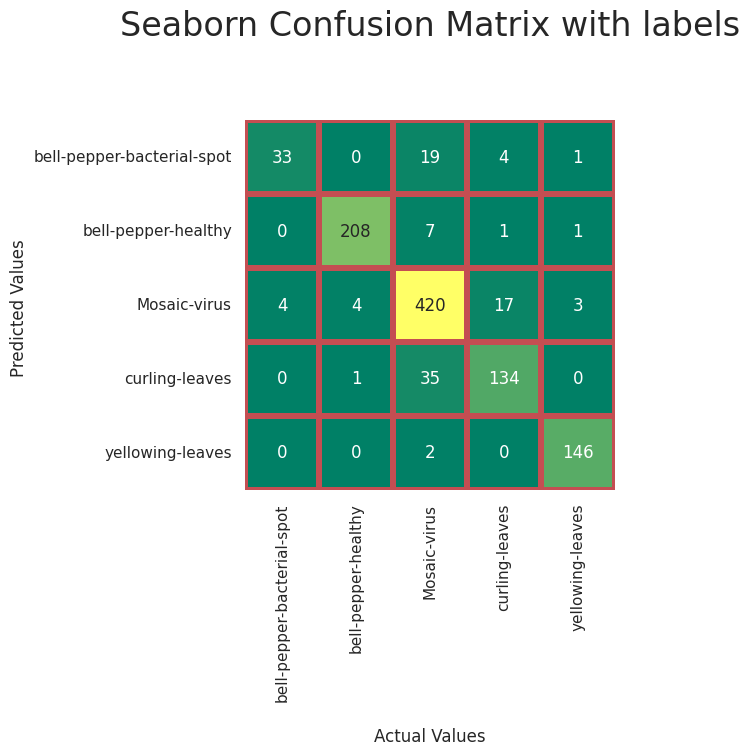

In [47]:
import seaborn as sns
sns.set(font_scale=1.0)
ax=sns.heatmap(cm, annot=True, cmap='summer', cbar=False, linewidths=3, linecolor='r', square=True, xticklabels=target_names,yticklabels=target_names,fmt='')
#sns.heatmap(cm, annot=True,annot_kws={"size": 22})
sns.set(font_scale = 2.0)
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nActual Values')
ax.set_ylabel('Predicted Values ');